## Requirements

In [23]:
# Import all required libraries
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
i = complex(0,1)
np.random.seed(8309)

# Import all functions from custom modules
from Load_data_yfiance import get_Today_data, save_to_csv, read_from_csv
from Fit_interp_regres import get_interp
from plot_2_interp import plot_two_interp
from plot_loc_vol_surface import plot_local_vol_surface
from heston import heston_simulation, fit_Heston_model
from garch import Garch_simulation,get_param_garch
from dupire import get_local_vol_surface, dupire_simulation
from BaseLineGBM import GBM_simulation

## Load Data

In [24]:
ticker = "^SPX"
spx = yf.Ticker(ticker)
r = 0.045

calls,date = get_Today_data(Ticker = spx, r = r)
save_to_csv(calls,date)
# calls = read_from_csv("2025-10-28.csv")

print("range of strike: ",calls["strike"].min(),calls["strike"].max())
print("range of ttm: ",calls["ttm"].min(),calls["ttm"].max())
print("number of options: ",calls.size)
calls.head()

range of strike:  6620.0 6990.0
range of ttm:  0.003968253968253968 0.45634920634920634
number of options:  1703


,strike,lastPrice,lastTradeDate,CP,exp,S0,ttm,exp_month,r,in_out,F,q,imp_vol
0,6710.0,167.40,2025-10-28 02:12:02+00:00,0,2025-10-29,6875.160156,0.003968,2510,0.045,in,6874.299875,0.076534,0.207226
1,6720.0,157.46,2025-10-28 02:12:02+00:00,0,2025-10-29,6875.160156,0.003968,2510,0.045,in,6874.299875,0.076534,0.198597
3,6790.0,87.02,2025-10-28 07:00:43+00:00,0,2025-10-29,6875.160156,0.003968,2510,0.045,in,6874.299875,0.076534,0.110373
4,6825.0,60.41,2025-10-28 00:37:11+00:00,0,2025-10-29,6875.160156,0.003968,2510,0.045,in,6874.299875,0.076534,0.159121
5,6830.0,55.11,2025-10-28 02:02:39+00:00,0,2025-10-29,6875.160156,0.003968,2510,0.045,in,6874.299875,0.076534,0.147989


# Base Line: Constant Vol GBM

In [25]:
spx = yf.download(ticker, period='31d')
spx['returns'] = np.log(spx['Close'] / spx['Close'].shift(1))
vol = spx['returns'].dropna().std()
vol_annual = vol * np.sqrt(252)
mu = spx['returns'].dropna().mean()
mu_annual = mu * 252
print("Annualized 30-days Mean:",mu_annual)
print("Annualized 30-days Volatility:",vol_annual)

[*********************100%***********************]  1 of 1 completed

Annualized 30-days Mean: 0.32367591059411815
Annualized 30-days Volatility: 0.1211693349979888


# Local Volitality Method

## Get Interpolation and Regression (as comparison)

In [26]:
interp,regres = get_interp(calls)
plot_two_interp(interp,regres,calls)

## Find and Plot Local Volitality

### Local Vol using Interpolation

In [27]:
impvol_interp = interp
params = [calls["S0"].iloc[0],calls["r"].iloc[0],impvol_interp]
local_vol_surface = get_local_vol_surface(calls,params)
plot_local_vol_surface(calls,local_vol_surface)

### local Vol using regression

In [28]:
impvol_interp = regres
params = [calls["S0"].iloc[0],calls["r"].iloc[0],impvol_interp]
local_vol_surface_ = get_local_vol_surface(calls,params)
plot_local_vol_surface(calls,local_vol_surface_)

# Heston Method

In [29]:
v0,kappa,theta,rho,sigma = fit_Heston_model(calls)
print("initial variance under risk-neutral dynamics")
print("v0:", v0)
print("rate of mean reversion of variance under risk-neutral dynamics")
print("kappa:", kappa)
print("long-term mean of variance under risk-neutral dynamics")
print("theta:", theta)
print("correlation between returns and variances under risk-neutral dynamics")
print("rho:", rho)
print("volatility of volatility")
print("sigma:", sigma)

initial variance under risk-neutral dynamics
v0: 0.02
rate of mean reversion of variance under risk-neutral dynamics
kappa: 2.0
long-term mean of variance under risk-neutral dynamics
theta: 0.02
correlation between returns and variances under risk-neutral dynamics
rho: -0.5
volatility of volatility
sigma: 0.02


# Garch Method

In [30]:
omega, alpha, beta = get_param_garch(ticker)
print("Omega:",omega)
print("Alpha:",alpha)
print("Beta:",beta)

[*********************100%***********************]  1 of 1 completed

Omega: 7.983814109427158e-06
Alpha: 0.04999999831833821
Beta: 0.899999999547471


# Path Simulated

## Set Up parameters

In [37]:
# Exercise price
K = 7500
# time in years
T = 0.5
# number of time steps in simulation
N = int(T*252)
# asset price
S0 = calls["S0"].iloc[0]
# risk-free rate
r = calls["r"].iloc[0]
# Divident rate
q = 0
# number of simulations
M = 100


## Plot Paths

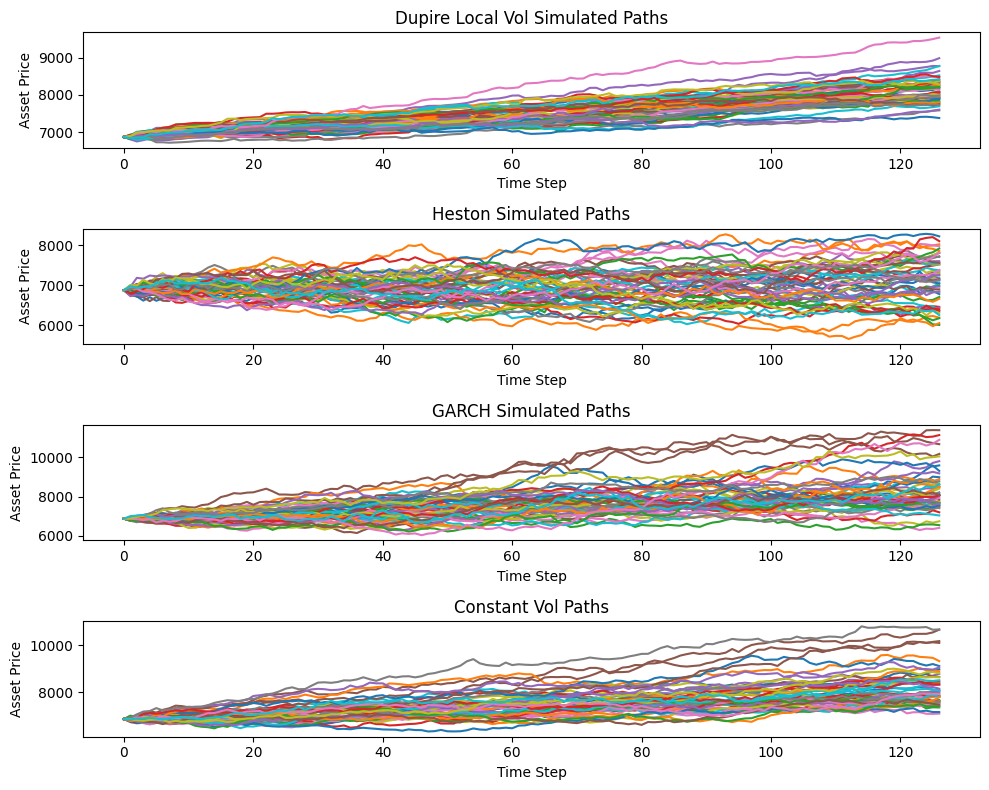

In [38]:
S_path_Heston,V_path_Heston = heston_simulation(S0=S0,r=r,q=q,K=K,T=T,v0=v0,kappa=kappa,theta=theta,rho=rho,sigma=sigma,M=M,N=N)
S_path_dupire,V_path_dupire = dupire_simulation(mu_annual=mu_annual,K=K,S0=S0,T=T,N=N,M=M, params=[calls["S0"].iloc[0],calls["r"].iloc[0],interp])
S_path_Garch, V_path_Garch = Garch_simulation(omega=omega, alpha=alpha, beta=beta,mu_annual=mu_annual,vol_annual=vol_annual,N=N,M=M,S0=S0,T=T)
S_path_GBM, V_path_GBM = GBM_simulation(vol_annual=vol_annual,mu_annual=mu_annual,S0=S0,T=T,N=N,M=M)
fig, axs = plt.subplots(4, 1, figsize=(10, 8))

axs[0].plot(S_path_dupire[:,:50])
axs[0].set_title("Dupire Local Vol Simulated Paths")
axs[0].set_xlabel("Time Step")
axs[0].set_ylabel("Asset Price")
axs[0].yaxis.set_major_formatter(ScalarFormatter(useOffset=False))

axs[1].plot(S_path_Heston[:,:50])
axs[1].set_title("Heston Simulated Paths")
axs[1].set_xlabel("Time Step")
axs[1].set_ylabel("Asset Price")
axs[1].yaxis.set_major_formatter(ScalarFormatter(useOffset=False))

axs[2].plot(S_path_Garch[:,:50])
axs[2].set_title("GARCH Simulated Paths")
axs[2].set_xlabel("Time Step")
axs[2].set_ylabel("Asset Price")
axs[2].yaxis.set_major_formatter(ScalarFormatter(useOffset=False))

axs[3].plot(S_path_GBM[:,:50])
axs[3].set_title("Constant Vol Paths")
axs[3].set_xlabel("Time Step")
axs[3].set_ylabel("Asset Price")
axs[3].yaxis.set_major_formatter(ScalarFormatter(useOffset=False))

plt.tight_layout()
plt.show()


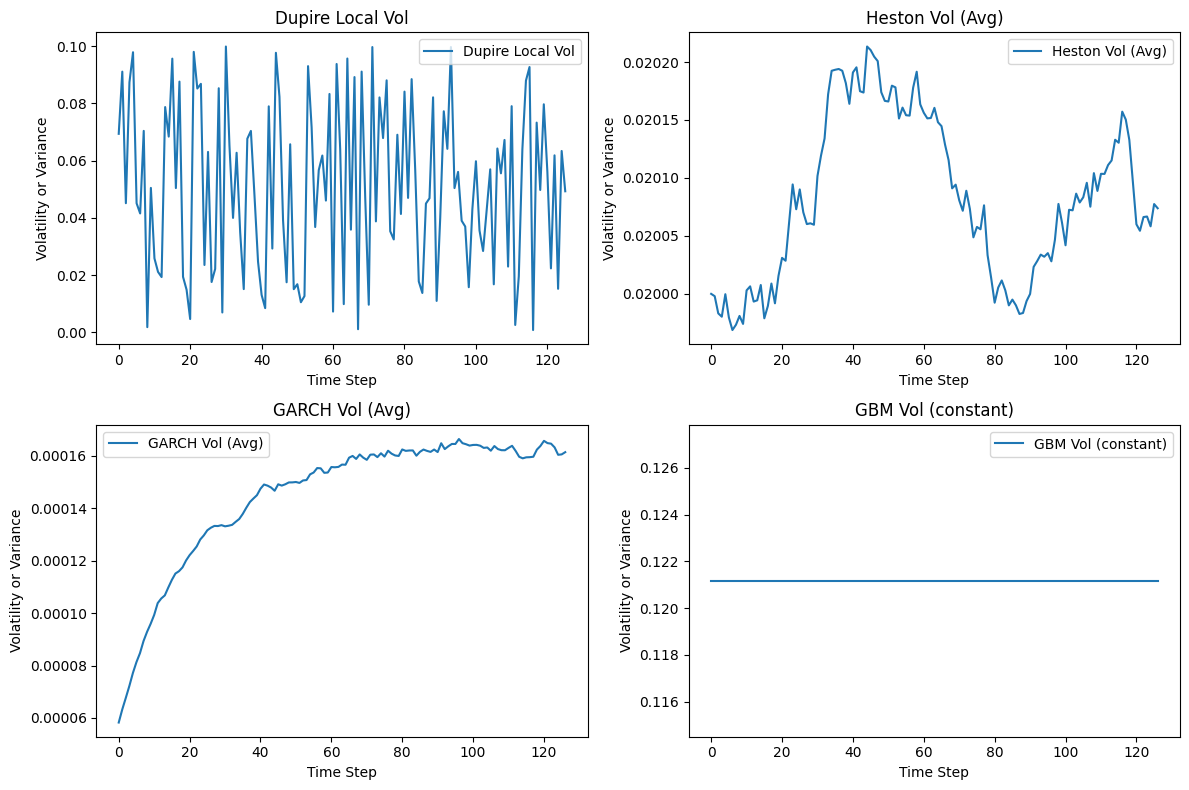

In [39]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

axs[0, 0].plot(V_path_dupire, label="Dupire Local Vol")
axs[0, 0].set_title("Dupire Local Vol")
axs[0, 0].set_xlabel("Time Step")
axs[0, 0].set_ylabel("Volatility or Variance")
axs[0, 0].legend()

axs[0, 1].plot(np.mean(V_path_Heston, axis=1), label="Heston Vol (Avg)")
axs[0, 1].set_title("Heston Vol (Avg)")
axs[0, 1].set_xlabel("Time Step")
axs[0, 1].set_ylabel("Volatility or Variance")
axs[0, 1].legend()

axs[1, 0].plot(np.mean(V_path_Garch, axis=1), label="GARCH Vol (Avg)")
axs[1, 0].set_title("GARCH Vol (Avg)")
axs[1, 0].set_xlabel("Time Step")
axs[1, 0].set_ylabel("Volatility or Variance")
axs[1, 0].legend()
axs[1, 1].plot(V_path_GBM, label="GBM Vol (constant)")
axs[1, 1].set_title("GBM Vol (constant)")
axs[1, 1].set_xlabel("Time Step")
axs[1, 1].set_ylabel("Volatility or Variance")
axs[1, 1].legend()
plt.tight_layout()
plt.show()